<a href="https://colab.research.google.com/github/ReemAlsharabi/CryptoRobustTraining/blob/main/FR/pin_FR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[code source](https://www.kaggle.com/code/ahmedboumedine/facerecognition-torch-resnet34)

[data source](https://www.kaggle.com/datasets/hereisburak/pins-face-recognition)

[Another code](https://www.kaggle.com/code/akshatmundra/let-s-do-some-face-recognition)

[Another code for Multitarget classification](https://www.kaggle.com/code/therockomanz/multitarget-facerecognition-inceptionresnetv2#Displaying-Images-of-Targets)

### deps

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

#pytorch libraries
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Pad, Compose, CenterCrop, ToPILImage, Normalize, ConvertImageDtype, Resize
from torch import nn, optim
from torch.nn import init, Linear, ReLU, Softmax
from torch.nn.init import xavier_uniform_
from torch.optim import SGD, Adam
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import WeightedRandomSampler

import datetime
from PIL import Image

from sklearn.utils import compute_class_weight

import torch.optim as opt
from google.colab import drive
import zipfile

import torch.nn.init as init
import os
import torch
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from glob import glob
from tqdm.notebook import tqdm
from termcolor import colored
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import random
from torchsummary import summary


In [2]:
def set_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f'Set seed {seed}')

set_seed(42)

Set seed 42


### data prep

In [3]:
# Mount Google Drive
drive.mount('/content/drive')
# Set path to zip file on Google Drive
zip_path = '/content/drive/MyDrive/pin/archive.zip'

# Set path to directory where unzipped data will be stored
data_path = '/content/pin'

# Unzip data from zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

Mounted at /content/drive


In [4]:
main_folder = '/content/pin/105_classes_pins_dataset/'

listdir = sorted(os.listdir(main_folder))

In [ ]:
listdir

In [6]:
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
size = 224
batch_size=64
channels = 3

transformer = T.Compose([
    T.Resize(size),
    T.CenterCrop(size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [7]:
dataset = ImageFolder(main_folder, transform=transformer)
classes = dataset.classes

len(dataset), dataset[0][0].size()

(17534, torch.Size([3, 224, 224]))

In [8]:
def denormal(image):
    image = image.numpy().transpose(1, 2, 0)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def denormalize(x, mean=stats[0], std=stats[1]):
    # 3, H, W, B
    ten = x.clone().permute(1, 2, 3, 0)
    for t, m, s in zip(ten, mean, std):
        t.mul_(s).add_(m)
    # B, 3, H, W
    return torch.clamp(ten, 0, 1).permute(3, 0, 1, 2)

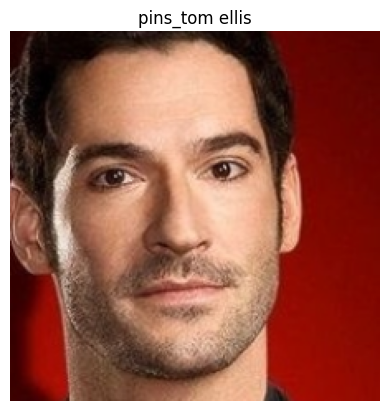

In [9]:
idx =  -1
img, lbl = dataset[idx]

plt.imshow(denormal(img))
plt.title(dataset.classes[lbl])
plt.axis('off');

In [32]:
num_val = int(len(dataset) * 0.3)

dataset, val_ds = random_split(dataset, [len(dataset) - num_val, num_val])
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


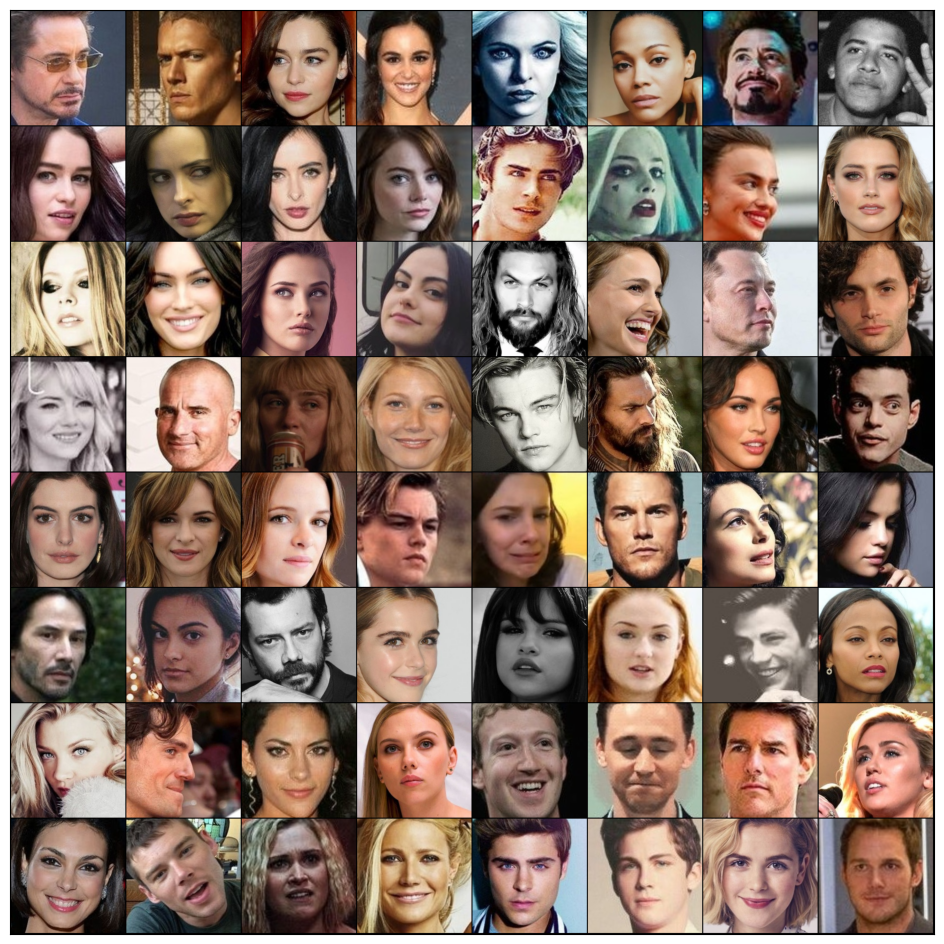

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
show_batch(dl)

### model

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:
class FaceRecog(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.resnet34 = models.vgg19(True)
        self.features = nn.Sequential(*list(self.resnet34.children())[:-1])
        # Replace last layer
        #self.classifier = nn.Sequential(nn.Flatten(),
                                         #nn.Linear(self.resnet34.fc.in_features, num_classes))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features=25088, out_features=num_classes))




    def forward(self, x):
        x= self.features(x)
        y = self.classifier(x)
        return y

    def summary(self, input_size):
        return summary(self, input_size)


In [35]:
model = FaceRecog(num_classes=len(classes)).to(device)
model.summary((3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
              ReLU-3         [-1, 64, 224, 224]               0
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
            Conv2d-6         [-1, 64, 224, 224]          36,928
              ReLU-7         [-1, 64, 224, 224]               0
              ReLU-8         [-1, 64, 224, 224]               0
         MaxPool2d-9         [-1, 64, 112, 112]               0
        MaxPool2d-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]          73,856
           Conv2d-12        [-1, 128, 112, 112]          73,856
             ReLU-13        [-1, 128, 112, 112]               0
             ReLU-14        [-1, 128, 1

### train (fine tune) & eval

In [16]:
learning_rate = 1e-4
n_epochs = 10

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
def train(epoch, n_epochs, model, dl, loss_func, device, optimizer, ds=dataset):
    model.train(True)
    torch.set_grad_enabled(True)

    epoch_loss = 0.0
    epochs_acc = 0

    tq_batch = tqdm(dl, total=len(dl))
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outs = model(images)
        _, preds = torch.max(outs, 1)

        loss = loss_func(outs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()

        tq_batch.set_description(f'Epoch [{epoch + 1}/{n_epochs}]')
        tq_batch.set_postfix_str('loss = {:.4f}'.format(loss.item()))


    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [19]:
def evaluate(model, dl, loss_func, device, ds=val_ds):

    model.train(False)

    epoch_loss = 0
    epochs_acc = 0
    tq_batch = tqdm(dl, total=len(dl), leave=False)
    for images, labels in tq_batch:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(outputs, labels)

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        tq_batch.set_description(f'Evaluate Model')

    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [20]:
def fit(n_epochs, model, train_dataloader, valid_dataloader, loss_func, device, optimizer):

    history = []
    val_loss_ref = float('inf')
    patient = 5
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        loss, acc = train(epoch, n_epochs, model, train_dataloader, loss_func, device, optimizer)

        torch.cuda.empty_cache()
        val_loss, val_acc = evaluate(model, valid_dataloader, loss_func, device)

        history.append({'loss': loss, 'acc': acc, 'val_loss': val_loss, 'val_acc': val_acc})

        statement = "[loss]={:.4f} - [acc]={:.4f} - \
[val_loss]={:.4f} - [val_acc]={:.4f}".format(loss, acc, val_loss, val_acc,)
        print(statement)
        ####### Checkpoint
        if val_loss < val_loss_ref:
            patient = 5
            val_loss_ref = val_loss
            model_path = './Face_Recognition_checkpoint.pth'
            torch.save(model.state_dict(), model_path)
            print(f"[INFO] Saving model dict, Epoch={epoch + 1}")
        else:
            if patient == 0:
                break
            print(f"[INFO] {patient} lives left!")
            patient -= 1


    return history

In [21]:
res = fit(n_epochs, model, dl, val_dl, criterion, device, optimizer)

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[loss]=2.8762 - [acc]=0.2918 - [val_loss]=1.8540 - [val_acc]=0.4962
[INFO] Saving model dict, Epoch=1


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[loss]=0.8844 - [acc]=0.7468 - [val_loss]=1.1892 - [val_acc]=0.6876
[INFO] Saving model dict, Epoch=2


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[loss]=0.2443 - [acc]=0.9249 - [val_loss]=1.3348 - [val_acc]=0.6774
[INFO] 5 lives left!


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[loss]=0.1285 - [acc]=0.9583 - [val_loss]=1.3676 - [val_acc]=0.7034
[INFO] 4 lives left!


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[loss]=0.1074 - [acc]=0.9654 - [val_loss]=1.7752 - [val_acc]=0.6622
[INFO] 3 lives left!


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[loss]=0.0805 - [acc]=0.9737 - [val_loss]=1.5495 - [val_acc]=0.7148
[INFO] 2 lives left!


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[loss]=0.0745 - [acc]=0.9777 - [val_loss]=1.2618 - [val_acc]=0.7237
[INFO] 1 lives left!


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[loss]=0.0751 - [acc]=0.9778 - [val_loss]=1.2556 - [val_acc]=0.7345


### evaluation

In [22]:
def show_results(history):
    accuracy = [res['acc'] for res in history]
    losses = [res['loss'] for res in history]
    val_accuracy = [res['val_acc'] for res in history]
    val_losses = [res['val_loss'] for res in history]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.plot(losses, '-o', label = 'Loss')
    ax1.plot(val_losses, '-o', label = 'Validation Loss')
    ax1.legend()

    ax2.plot(100 * np.array(accuracy), '-o', label = 'Accuracy')
    ax2.plot(100 * np.array(val_accuracy), '-o', label = 'Validation Accuracy')
    ax2.legend();

    fig.show()

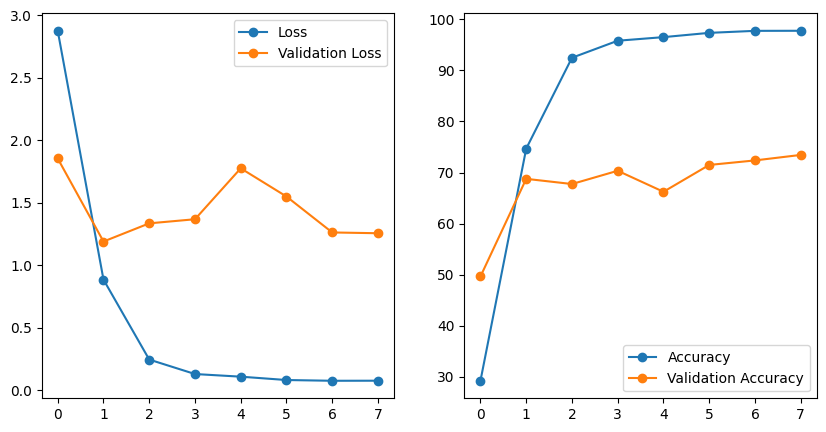

In [23]:
show_results(res)

In [24]:
y_test, y_pred = [], []
for imgs, lbls in tqdm(val_dl):
    imgs = imgs.to(device)
    outs = model(imgs)
    _, preds = torch.max(outs, dim = 1)
    y_test += lbls.tolist()
    y_pred += preds.tolist()

  0%|          | 0/25 [00:00<?, ?it/s]

In [25]:
loss, acc = evaluate(model, val_dl, criterion, device)
print(f'loss: {loss} - acc: {acc}')

  0%|          | 0/25 [00:00<?, ?it/s]

loss: 1.2526063179969789 - acc: 0.7344740177439797


In [26]:
for i, name in enumerate(classes):
    name = name.split("_")[-1]
    classes[i] = name

# classes

Millie Bobby Brown
Morena Baccarin
Mark Ruffalo
amber heard
Brenton Thwaites
Eliza Taylor
grant gustin Brenton Thwaites
Katharine Mcphee Taylor Swift
Emma Watson
Neil Patrick Harris
Andy Samberg
Ursula Corbero Irina Shayk
Eliza Taylor
Anne Hathaway
Morena Baccarin
Chris Hemsworth


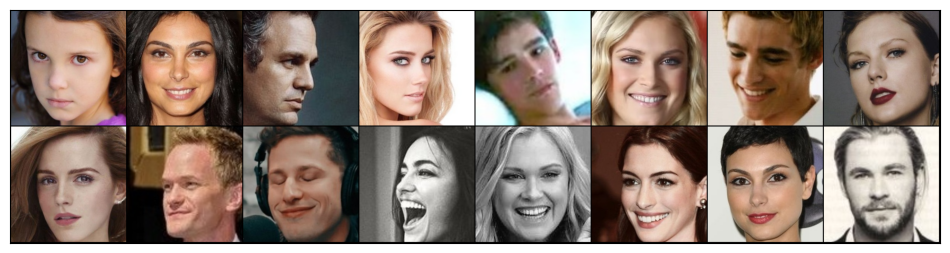

In [27]:
idx = 16
for imgs, lbls in val_dl:
    imgs = imgs.to(device)
    outs = model(imgs)
    _, preds = torch.max(outs, dim = 1)
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(imgs.cpu())
    ax.imshow(make_grid(denorm_images[:idx], nrow=8).permute(1, 2, 0).clamp(0,1))
    for p, lbl in zip(preds[:idx], lbls[:idx]):
        if lbl == p.cpu():
            print(colored(classes[p], 'green'))
        else:
            print(colored(classes[p], 'red'), colored(classes[lbl], 'blue'))
    break

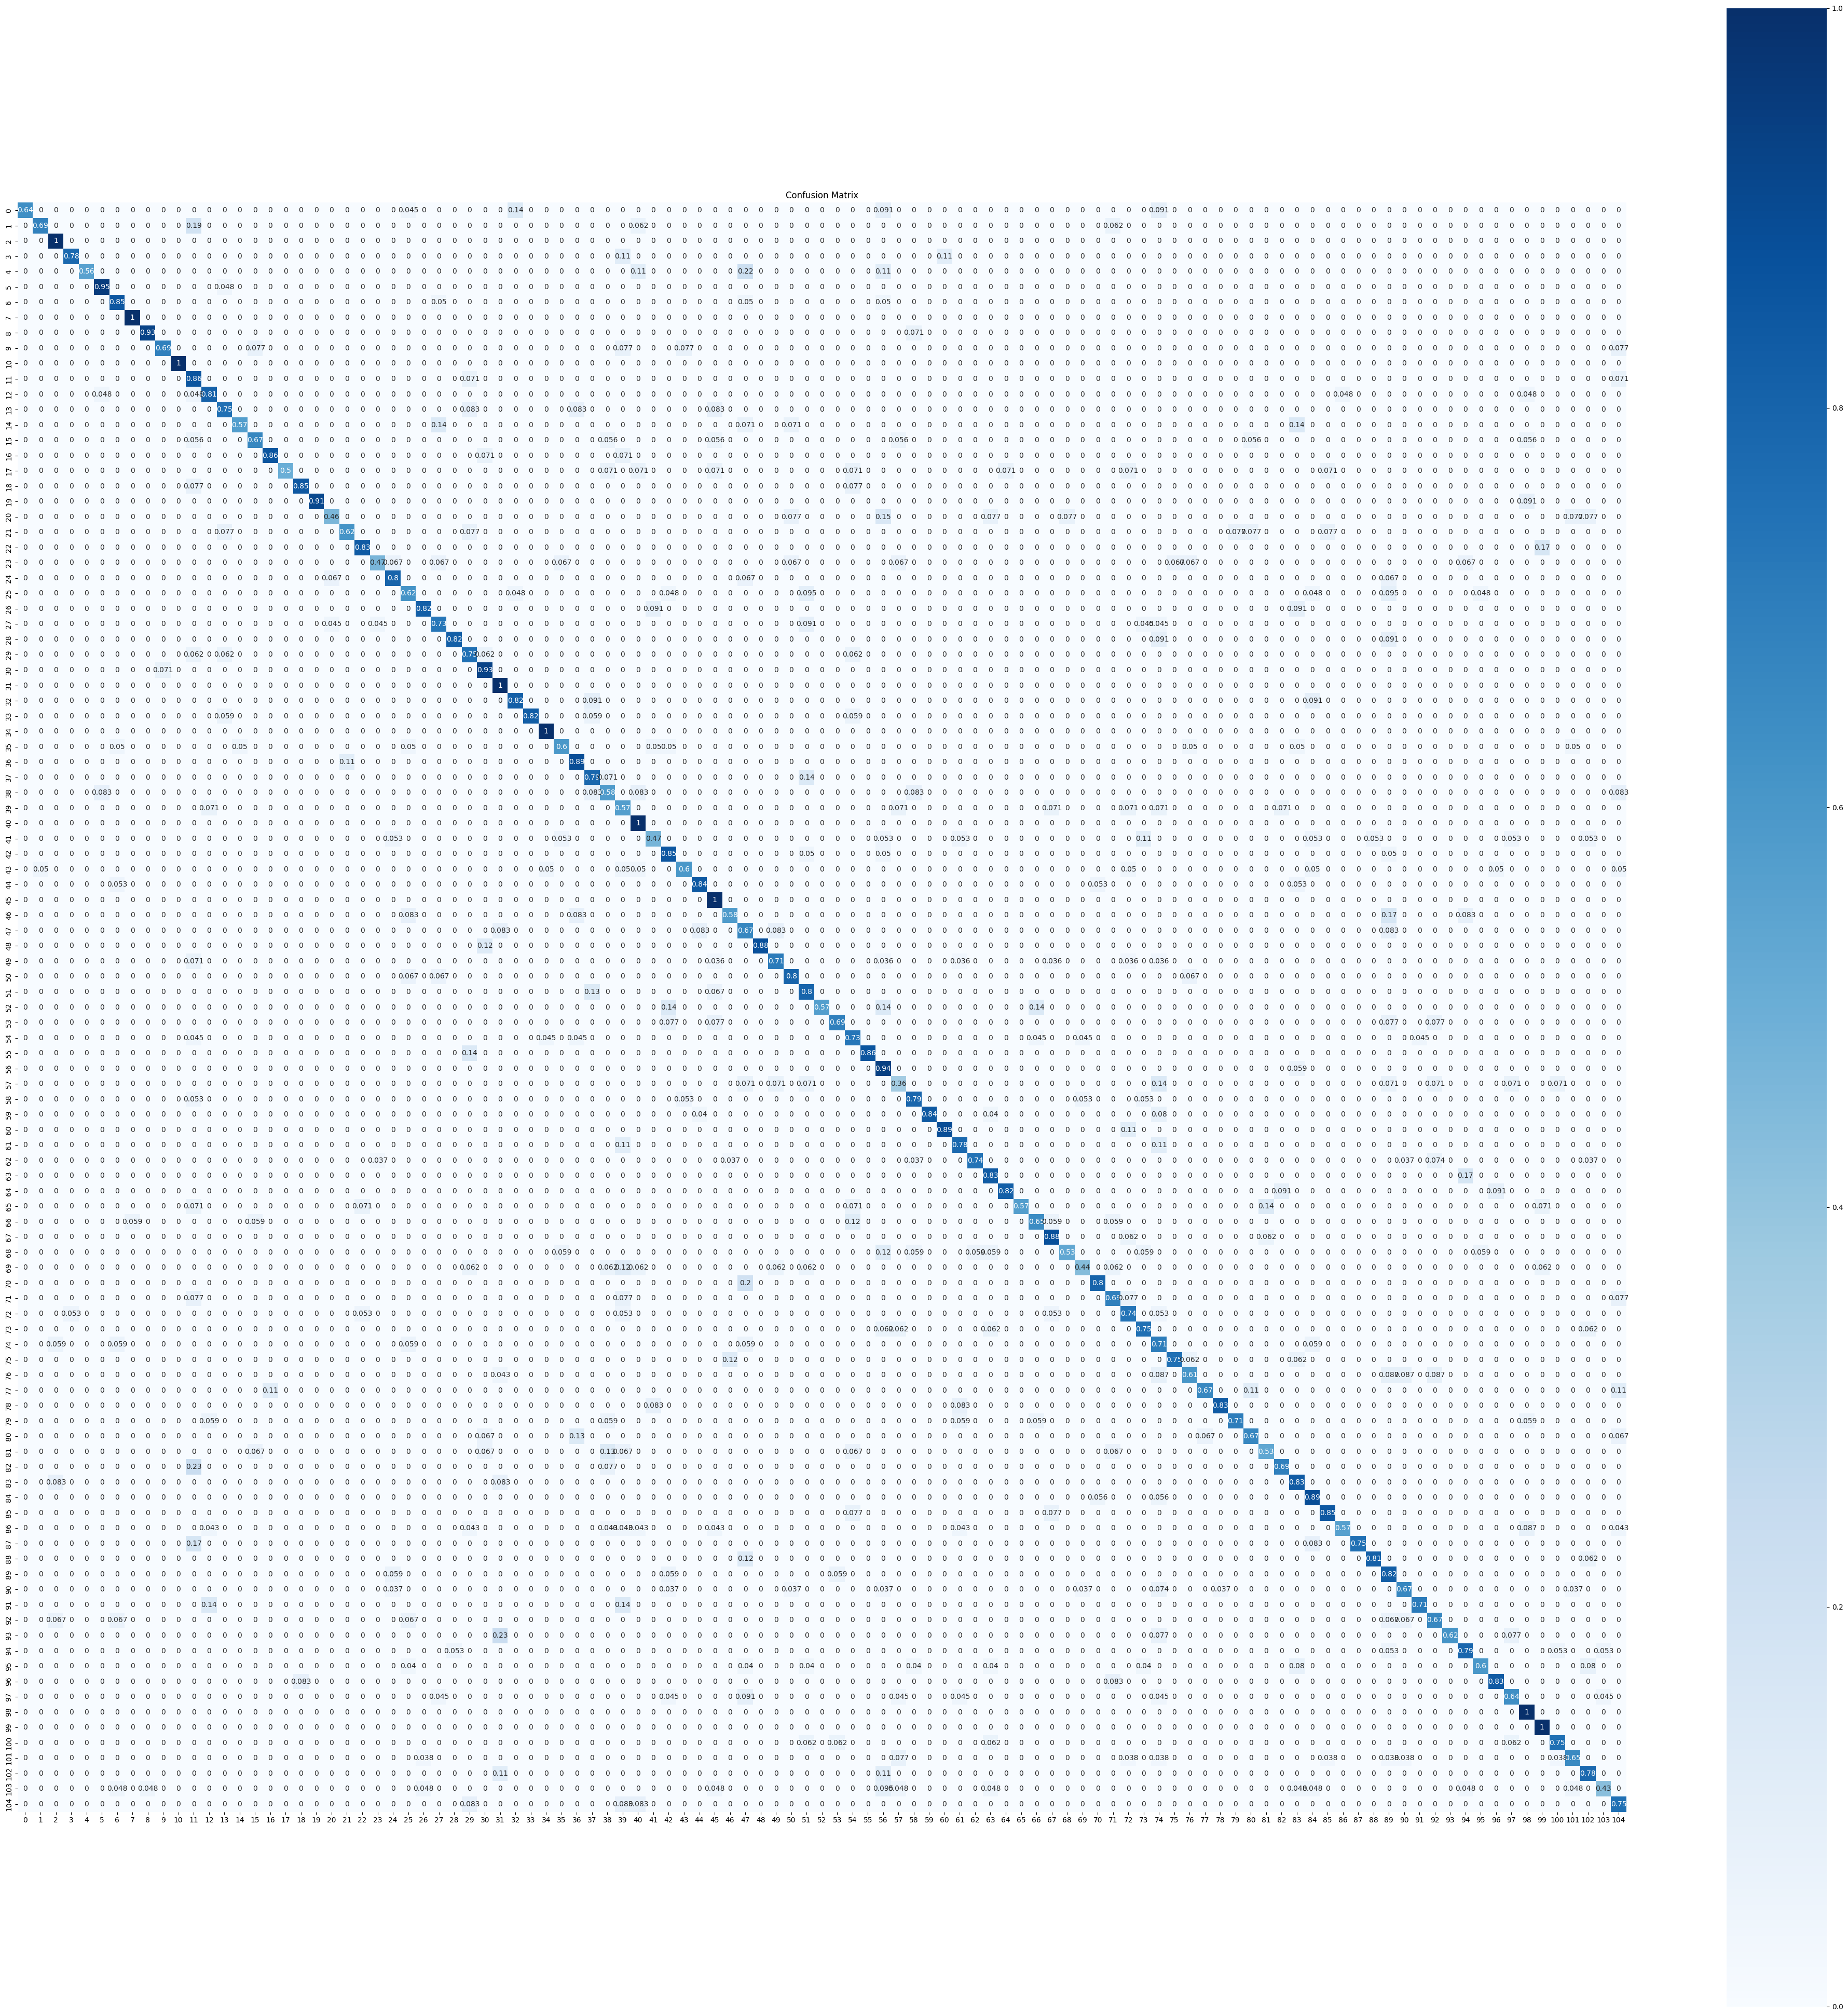

In [28]:
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(50, 50))
plt.title('Confusion Matrix')
sns.heatmap(cm_df, annot=True, cmap='Blues', square=True);

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        22
           1       0.92      0.69      0.79        16
           2       0.79      1.00      0.88        11
           3       0.88      0.78      0.82         9
           4       1.00      0.56      0.71         9
           5       0.91      0.95      0.93        21
           6       0.77      0.85      0.81        20
           7       0.90      1.00      0.95         9
           8       0.93      0.93      0.93        14
           9       0.90      0.69      0.78        13
          10       1.00      1.00      1.00         6
          11       0.40      0.86      0.55        14
          12       0.81      0.81      0.81        21
          13       0.69      0.75      0.72        12
          14       0.89      0.57      0.70        14
          15       0.80      0.67      0.73        18
          16       0.92      0.86      0.89        14
          17       1.00    

### save the model

In [30]:
torch.save(model.state_dict(), 'model.pth')

In [31]:
# Save weights to mounted drive
weights_path = "/content/drive/MyDrive/pin/model_weights.pth"
torch.save(model.state_dict(), weights_path)